In [1]:
pip install -q transformers


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv


In [4]:
DATA_ROOT = Path("..") / "/kaggle/input/sentiment-analysis-on-movie-reviews"
train = pd.read_csv(DATA_ROOT / 'train.tsv.zip', sep="\t")
test = pd.read_csv(DATA_ROOT / 'test.tsv.zip', sep="\t")
print(train.shape,test.shape)
train.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [6]:

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False


In [7]:
seed = 42
use_fp16 = False
bs = 16
seed_all(seed)
model_type = 'roberta'
pretrained_model_name = 'roberta-base'

In [8]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]


In [9]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [10]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [11]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [12]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [13]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [14]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [15]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [16]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
"<s> Ġ- L RB - ĠCity Ġ- RR B - Ġreminds Ġus Ġhow Ġrealistically Ġnuanced Ġa ĠRobert ĠDe ĠN iro Ġperformance Ġcan Ġbe Ġwhen Ġhe Ġis Ġnot Ġmore Ġluc r atively Ġengaged Ġin Ġthe Ġshameless Ġself - car ic ature Ġof Ġ` ĠAnaly ze ĠThis Ġ' Ġ- L RB - Ġ1999 Ġ- RR B - Ġand Ġ` ĠAnaly ze ĠThat Ġ, Ġ' Ġpromised Ġ- L RB - Ġor Ġthreatened Ġ-",3
"<s> ĠThe Ġreal Ġtriumph s Ġin ĠIg by Ġcome Ġfrom ĠPhilippe Ġ, Ġwho Ġmakes ĠOliver Ġfar Ġmore Ġinteresting Ġthan Ġthe Ġcharacter Ġ' s Ġlines Ġwould Ġsuggest Ġ, Ġand ĠSar andon Ġ, Ġwho Ġcould Ġn 't Ġbe Ġbetter Ġas Ġa Ġcruel Ġbut Ġweird ly Ġlik able ĠWAS P Ġmat ron Ġ. </s>",3
"<s> ĠParker Ġshould Ġbe Ġcomm ended Ġfor Ġtaking Ġa Ġfresh Ġapproach Ġto Ġfamiliar Ġmaterial Ġ, Ġbut Ġhis Ġdetermination Ġto Ġremain Ġtrue Ġto Ġthe Ġoriginal Ġtext Ġleads Ġhim Ġto Ġadopt Ġa Ġsomewhat Ġman nered Ġtone Ġ... Ġthat Ġultimately Ġdull s Ġthe Ġhuman Ġtragedy Ġat Ġthe Ġstory Ġ' s Ġcore </s>",2
"<s> ĠIt Ġ' s Ġa Ġlong Ġway Ġfrom ĠOrwell Ġ' s Ġdark Ġ, Ġintelligent Ġwarning Ġcry Ġ- L RB - Ġ1984 Ġ- RR B - Ġto Ġthe Ġempty Ġstud Ġknock about Ġof ĠEqu ilibrium Ġ, Ġand Ġwhat Ġonce Ġwas Ġconviction Ġis Ġnow Ġaffect ation Ġ. </s>",1
"<s> ĠA Ġdifferent Ġand Ġemotionally Ġreserved Ġtype Ġof Ġsurvival Ġstory Ġ-- Ġa Ġfilm Ġless Ġabout Ġref ract ing Ġall Ġof ĠWorld ĠWar ĠII Ġthrough Ġthe Ġspecific Ġconditions Ġof Ġone Ġman Ġ, Ġand Ġmore Ġabout Ġthat Ġman Ġlost Ġin Ġits Ġmidst Ġ. </s>",3


In [17]:
#Check batch and numericalizer

print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 79])
tensor([[    0,   111,   574,  ...,    76,   479,     2],
        [    0,    33,     7,  ...,     1,     1,     1],
        [    0,   318,    47,  ...,     1,     1,     1],
        ...,
        [    0,     5,  2156,  ...,     1,     1,     1],
        [    0,    33, 30291,  ...,     1,     1,     1],
        [    0, 45518, 10730,  ...,     1,     1,     1]])


In [18]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [19]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [20]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [21]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [22]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [23]:
#Splitting the model into layers
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [24]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in ', num_groups, 'groups')
print(learner.layer_groups)

Learner split in  14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2

In [25]:
#Training 

learner.save('untrain')


In [26]:

seed_all(seed)
learner.load('untrain')


Learner(data=TextClasDataBunch;

Train: LabelList (140454 items)
x: TextList
<s> ĠA Ġseries Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>,<s> ĠA Ġseries </s>,<s> ĠA </s>,<s> Ġseries </s>,<s> Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>
y: CategoryList
2,2,2,2,2
Path: .;

Valid: LabelList (15606 items)
x: TextList
<s> Ġ' s Ġas Ġsorry </s>,<s> ĠRomantic Ġcomedy Ġand ĠDog me Ġ95 Ġfilmmaking Ġmay Ġseem Ġodd Ġbed fell ows Ġ, Ġbut Ġthey Ġturn Ġout Ġto Ġbe Ġdelight fully Ġcompatible Ġhere </s>,<s> Ġof Ġthese Ġdays </s>,<s> Ġfl inch Ġfrom Ġits Ġunsettling Ġprog nosis </s>,<s> Ġare Ġclinically Ġdepressed </s>
y: CategoryList
2,4,2,2,1
Path: .;

Test: LabelList (66292 items)
x: TextList
<s> Ġ15 60 61 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort Ġ. </s>,<s> Ġ15 60 62 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort </s>,<s> Ġ15 60 63 Ġ85 45 ĠAn </s>,<s> Ġ15 60 64 Ġ85 45

In [27]:
learner.freeze_to(-1)


In [28]:

learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [79, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [79, 768]            394,752    False     
______________________________________________________________________
Embedding            [79, 768]            768        False     
______________________________________________________________________
LayerNorm            [79, 768]            1,536      False     
______________________________________________________________________
Dropout              [79, 768]            0          False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
_______________________________________

In [29]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03
Min loss divided by 10: 4.37E-04


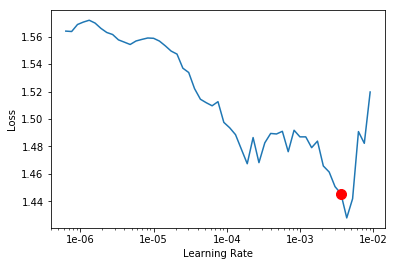

In [30]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.011049,0.986579,0.600602,0.399398,03:49


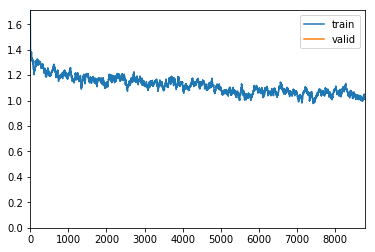

In [31]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.2,0.7))

In [32]:
learner.save('first_cycle')

In [33]:
seed_all(seed)
learner.load('first_cycle')

Learner(data=TextClasDataBunch;

Train: LabelList (140454 items)
x: TextList
<s> ĠA Ġseries Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>,<s> ĠA Ġseries </s>,<s> ĠA </s>,<s> Ġseries </s>,<s> Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>
y: CategoryList
2,2,2,2,2
Path: .;

Valid: LabelList (15606 items)
x: TextList
<s> Ġ' s Ġas Ġsorry </s>,<s> ĠRomantic Ġcomedy Ġand ĠDog me Ġ95 Ġfilmmaking Ġmay Ġseem Ġodd Ġbed fell ows Ġ, Ġbut Ġthey Ġturn Ġout Ġto Ġbe Ġdelight fully Ġcompatible Ġhere </s>,<s> Ġof Ġthese Ġdays </s>,<s> Ġfl inch Ġfrom Ġits Ġunsettling Ġprog nosis </s>,<s> Ġare Ġclinically Ġdepressed </s>
y: CategoryList
2,4,2,2,1
Path: .;

Test: LabelList (66292 items)
x: TextList
<s> Ġ15 60 61 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort Ġ. </s>,<s> Ġ15 60 62 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort </s>,<s> Ġ15 60 63 Ġ85 45 ĠAn </s>,<s> Ġ15 60 64 Ġ85 45

In [34]:
learner.freeze_to(-2)

In [35]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.923600,0.901293,0.635973,0.364027,04:27


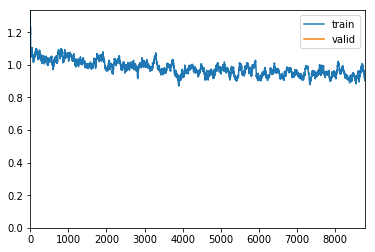

In [36]:
learner.fit_one_cycle(1,max_lr=slice(lr*0.95**num_groups,lr), moms=(0.8,0.9))

In [37]:
learner.save('third_cycle')

In [38]:
seed_all(seed)
learner.load('third_cycle')

Learner(data=TextClasDataBunch;

Train: LabelList (140454 items)
x: TextList
<s> ĠA Ġseries Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>,<s> ĠA Ġseries </s>,<s> ĠA </s>,<s> Ġseries </s>,<s> Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>
y: CategoryList
2,2,2,2,2
Path: .;

Valid: LabelList (15606 items)
x: TextList
<s> Ġ' s Ġas Ġsorry </s>,<s> ĠRomantic Ġcomedy Ġand ĠDog me Ġ95 Ġfilmmaking Ġmay Ġseem Ġodd Ġbed fell ows Ġ, Ġbut Ġthey Ġturn Ġout Ġto Ġbe Ġdelight fully Ġcompatible Ġhere </s>,<s> Ġof Ġthese Ġdays </s>,<s> Ġfl inch Ġfrom Ġits Ġunsettling Ġprog nosis </s>,<s> Ġare Ġclinically Ġdepressed </s>
y: CategoryList
2,4,2,2,1
Path: .;

Test: LabelList (66292 items)
x: TextList
<s> Ġ15 60 61 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort Ġ. </s>,<s> Ġ15 60 62 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort </s>,<s> Ġ15 60 63 Ġ85 45 ĠAn </s>,<s> Ġ15 60 64 Ġ85 45

In [39]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.702524,0.712802,0.698065,0.301935,11:28


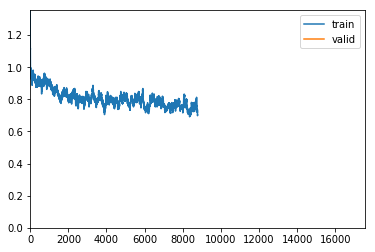

In [40]:
learner.fit_one_cycle(2,max_lr=slice(lr*0.95**num_groups,lr), moms=(0.8,0.9))

In [41]:
learner.predict('This is the best movie of 2020')

(Category 4,
 tensor(4),
 tensor([2.6298e-06, 6.0201e-06, 1.8474e-04, 2.4851e-02, 9.7496e-01]))

In [42]:
learner.predict('This is the Worst movie of 2020')

(Category 0,
 tensor(0),
 tensor([9.7829e-01, 2.1036e-02, 5.6067e-04, 4.5482e-05, 6.8512e-05]))

In [43]:
learner.export(file = 'transformer.pkl')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CustomTransformerModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RobertaForSequenceClassification. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RobertaModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ +

In [44]:
learner.export(file = 'transformer.pkl')

In [45]:
path = '/kaggle/working'
export_learner = load_learner(path, file = 'transformer.pkl')

In [46]:
export_learner.predict('This is the worst movie of 2020')

(Category 0,
 tensor(0),
 tensor([9.7880e-01, 2.0577e-02, 5.1839e-04, 4.1991e-05, 6.2210e-05]))

In [47]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [48]:
sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("predictions.csv", index=False)

In [49]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [50]:
sample_submission.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
